In [84]:
from binance.client import Client
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

_binance_config_file = 'binance_api.json'

_coin_color = {'BNBUSDT':'gold', 'BTCUSDT':'orange', 
               'ETHUSDT':'royalblue', 'XRP':'slategrey', 
               'LTCUSDT':'deepskyblue', 'EOSUSDT':'darkcyan'}

def load_config():
    with open(_binance_config_file, 'r') as read_file:
        return json.load(read_file)

def create_client():
    cfg = load_config()
    return Client(cfg['API Key'], cfg['Secret Key'])

def get_random_color():
    return tuple(random.shuffle([255,0,0]))

def get_coin_color(key):
    return _coin_color.get(key, '#FFFFFF')
    #return _coin_color.get(key, get_random_color())

class Coin():
    def __init__(self, ticker):
        self.ticker = ticker
        self.timeserie = {}
        self.correlation = {}
        self.__ignorecols = [6,7,8,9,10,11]
        self.__colnames = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        self.__color = get_coin_color(ticker)
        self.__figsize = (20, 5)

    def convert_timestamp(self):
        self.timeserie['Date'] = [datetime.utcfromtimestamp(ts/1000).strftime('%m-%d-%Y') for ts in self.timeserie['Date']]
        self.timeserie.index = pd.to_datetime(self.timeserie['Date'])
        self.timeserie = self.timeserie.loc[:,'Open':]
        return self
        
    def convert_dtypes(self):
        for col in self.timeserie.loc[:,'Open':].columns:
            self.timeserie[col] = pd.to_numeric(self.timeserie[col])
        return self
        
    def parse_timeserie(self, _timeserie):
        self.timeserie = pd.DataFrame(_timeserie).drop(self.__ignorecols, axis=1)
        self.timeserie.columns = self.__colnames
        self.convert_timestamp()
        self.convert_dtypes()
        return self
        
    def get_daily_hist_ohlcv(self, client, start_date):
        _timeserie = client.get_historical_klines(self.ticker, Client.KLINE_INTERVAL_1DAY, start_date)
        self.parse_timeserie( _timeserie)
        return self
     
    def scale(self, df):
        return (df - df.min()) * 1.0 / (df.max() - df.min())

    def get_correlation(self, coins):
        df = pd.DataFrame()
        df[self.ticker] = self.timeserie['Close']
        for coin in coins:
            df[coin.ticker] = coin.timeserie['Close']
            
        self.correlation = df.corr()
        
    def plot_correlation(self):
        f, ax = plt.subplots(figsize=(10, 10))
        cmap = sns.diverging_palette(220, 20, as_cmap=True)
        sns.heatmap(self.correlation, cmap=cmap, vmax=1, center=0, annot=True,
                    square=True, linewidths=.5, cbar_kws={"shrink": .7})
        plt.title('Coins Correlation', fontsize=20)
        plt.show()
    
    def plot_timeserie(self):
        ax = self.timeserie['Close'].plot(figsize=self.__figsize, color=self.__color)
        ax.set_title(self.ticker+' Price Series', fontsize=20)
        plt.show()
        
    def plot_compare(self, coins):
        
        fig, ax = plt.subplots(figsize=self.__figsize)
        ax.plot(self.scale(self.timeserie['Close']), color=self.__color)
        legend = [self.ticker]
        
        for coin in coins:
            legend.append(coin.ticker)
            ax.plot(self.scale(coin.timeserie['Close']), coin.__color)
        ax.set_title('Coin Comparison', fontsize=20)
        legend = ax.legend(legend)
        plt.show()  

def merge_coins(coins):
    df = pd.DataFrame()
    for coin in coins:
        df = pd.concat([df, coin.timeserie['Close']], axis=1)
    df.columns = [coin.ticker for coin in coins]
    return df

def construct_portfolios(coins):

    # calculate daily and annual returns of the stocks
    returns_daily = coins.pct_change()
    returns_annual = returns_daily.mean() * 250

    # get daily and covariance of returns of the stock
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * 250

    # empty lists to store returns, volatility and weights of imiginary portfolios
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    # set the number of combinations for imaginary portfolios
    num_assets = len(coins.columns)
    num_portfolios = 50000

    # populate the empty lists with each portfolios returns,risk and weights
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = returns / volatility
        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)

    # a dictionary for Returns and Risk values of each portfolio
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility,
                 'Sharpe Ratio': sharpe_ratio}

    # extend original dictionary to accomodate each ticker and weight in the portfolio
    for counter,symbol in enumerate(coins.columns):
        portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

    # make a nice dataframe of the extended dictionary
    df = pd.DataFrame(portfolio)

    # get better labels for desired arrangement of columns
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in coins.columns]

    # reorder dataframe columns
    df = df[column_order]
    
    # find min Volatility & max sharpe values in the dataframe (df)
    min_volatility = df['Volatility'].min()
    max_sharpe = df['Sharpe Ratio'].max()

    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    plt.style.use('seaborn-dark')
    plt.scatter(x=df['Volatility'], y=df['Returns'], c=df['Sharpe Ratio'], cmap='viridis')
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier')
    plt.grid('on')
    plt.show()
    return df
    

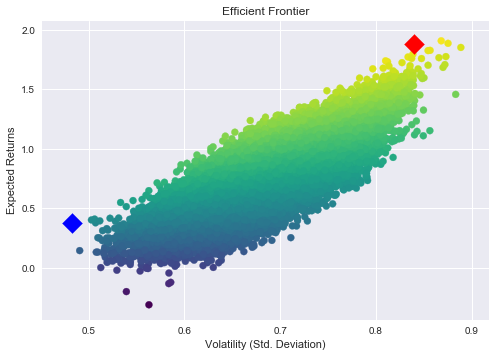

In [94]:
# Create Binance API client
client = create_client()

# Set start date
start_date = '01-01-2019'

# Get coins price series
BNB = Coin('BNBUSDT').get_daily_hist_ohlcv(client, start_date)
BTC = Coin('BTCUSDT').get_daily_hist_ohlcv(client, start_date)
ETH = Coin('ETHUSDT').get_daily_hist_ohlcv(client, start_date)
XRP = Coin('XRPUSDT').get_daily_hist_ohlcv(client, start_date)
LTC = Coin('LTCUSDT').get_daily_hist_ohlcv(client, start_date)
EOS = Coin('EOSUSDT').get_daily_hist_ohlcv(client, start_date)
ADA = Coin('ADAUSDT').get_daily_hist_ohlcv(client, start_date)

coins = merge_coins([BTC, ETH, XRP, LTC, EOS, ADA])

df = construct_portfolios(coins)


In [95]:
# Portfolio with highest sharpe ratio
df[df['Sharpe Ratio'] == df['Sharpe Ratio'].max()]

,Returns,Volatility,Sharpe Ratio,BTCUSDT Weight,ETHUSDT Weight,XRPUSDT Weight,LTCUSDT Weight,EOSUSDT Weight,ADAUSDT Weight
47068,1.878591,0.839134,2.238725,0.074799,0.004538,0.043936,0.729955,0.014503,0.132269


In [102]:
# Portfolio with lowest volatility
df[df['Volatility'] == df['Volatility'].min()]

,Returns,Volatility,Sharpe Ratio,BTCUSDT Weight,ETHUSDT Weight,XRPUSDT Weight,LTCUSDT Weight,EOSUSDT Weight,ADAUSDT Weight
49779,0.374976,0.483091,0.776202,0.740117,0.00937,0.048124,0.07727,0.00514,0.119979
